In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance

# Import and Cleaning

In [3]:
df = pd.read_csv('E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# specify selected price-quantity columns
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [5]:
pd.set_option('display.max_columns', None)

# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]

#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

In [6]:
# Convert 'run_time' to datetime with multiple formats
result_df['temp_run_time'] = pd.to_datetime(result_df['run_time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p').copy()

# Handle the remaining date-only format separately
mask_date_only = result_df['temp_run_time'].dt.time == pd.Timestamp('00:00:00').time()
result_df['run_time'] = result_df['temp_run_time'].where(mask_date_only, result_df['temp_run_time'].combine_first(pd.to_datetime(result_df['temp_run_time'], errors='coerce', format='%m/%d/%Y')))

# Drop the temporary column
result_df.drop(columns=['temp_run_time'], inplace=True)

# Print the result
result_df.head()

C:\Users\Gaea\AppData\Local\Temp\ipykernel_32456\2423218759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['temp_run_time'] = pd.to_datetime(result_df['run_time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p').copy()
C:\Users\Gaea\AppData\Local\Temp\ipykernel_32456\2423218759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['temp_run_time'].where(mask_date_only, result_df['temp_run_time'].combine_first(pd.to_datetime(result_df['temp_run_time'], errors='c

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,NaT,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-26 00:05:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-26 00:10:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-26 00:15:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-26 00:20:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
starting_index = 6
downsampled_df = result_df.iloc[starting_index::12, :].copy()  # Use .copy() to create a copy of the DataFrame
downsampled_df.reset_index(drop=True, inplace=True)
downsampled_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2021-06-26 00:30:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-26 01:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,450.0,538.2,556.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
2,2021-06-26 02:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,436.2,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
3,2021-06-26 03:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,435.0,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
4,2021-06-26 04:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,436.9,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17309,2023-09-25 19:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17310,2023-09-25 20:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17311,2023-09-25 21:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17312,2023-09-25 22:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN


## FFill NaNs with Last Price-Quantity Bid

In [9]:
# Forward fill from the first non-null value in each row for the price columns
downsampled_df.loc[:, 'price1':'price11'] = downsampled_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
downsampled_df.loc[:, 'quantity1':'quantity11'] = downsampled_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

downsampled_df.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2021-06-26 00:30:00,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,0.0,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
1,2021-06-26 01:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,450.0,538.2,556.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
2,2021-06-26 02:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,436.2,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
3,2021-06-26 03:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,435.0,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
4,2021-06-26 04:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,436.9,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0


## MinMaxScaler on Quantity values

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = downsampled_df[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(downsampled_df[quantity_columns].shape)

# Update the DataFrame with the scaled values
downsampled_df.loc[:, quantity_columns] = scaled_quantities

# K-medoids

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get values from columns
prices = downsampled_df[['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']].values
quantities = downsampled_df[['quantity1', 'quantity2', 'quantity3', 'quantity4', 'quantity5', 'quantity6', 'quantity7', 'quantity8', 'quantity9', 'quantity10', 'quantity11']].values

# Function to create step-wise bid curves
def create_stepwise_curves(prices, quantities):
    step_curves = []
    for i in range(len(prices)):
        step_curves.append(list(zip(quantities[i], prices[i])))
    return step_curves

step_curves = create_stepwise_curves(prices, quantities)

In [29]:
step_curves

[[(0.0, -10000.0),
  (0.8361669242658424, -10000.0),
  (0.9778979907264297, 2214.38),
  (1.0, 2465.69),
  (1.0, 2465.69),
  (1.0, 2465.69),
  (1.0, 2465.69),
  (1.0, 2465.69),
  (1.0, 2465.69),
  (1.0, 2465.69),
  (1.0, 2465.69)],
 [(0.0, -10000.0),
  (0.6955177743431221, -10000.0),
  (0.8318392581143741, 2214.38),
  (0.8593508500772797, 2465.69),
  (0.865533230293663, 2470.08),
  (0.9273570324574961, 2480.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
  (1.0, 2490.08)],
 [(0.0, -10000.0),
  (0.5409582689335394, -10000.0),
  (0.6741885625965996, 2214.38),
  (0.704791344667697, 2465.69),
  (0.865533230293663, 2470.08),
  (0.9273570324574961, 2480.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
  (1.0, 2490.08)],
 [(0.0, -10000.0),
  (0.5409582689335394, -10000.0),
  (0.6723338485316847, 2214.38),
  (0.704791344667697, 2465.69),
  (0.865533230293663, 2470.08),
  (0.9273570324574961, 2480.08),
  (1.0, 2490.08),
  (1.0, 2490.08),
 

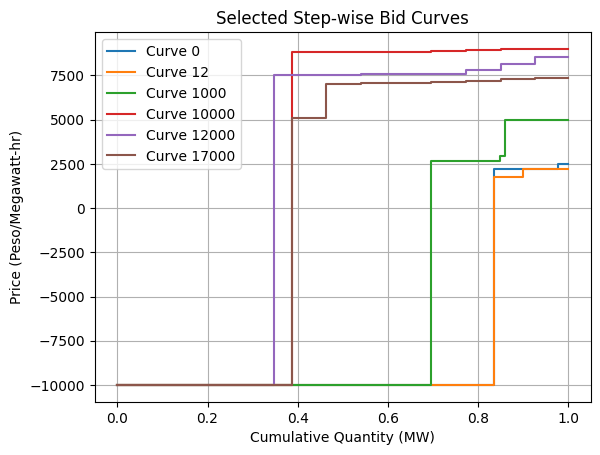

In [13]:
# Test Plot random indices
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 1000, 10000, 12000, 17000]

# Extract prices and cumulative quantities for the specified indices
selected_prices = downsampled_df.iloc[indices_to_plot, 1:12].values  # Assuming columns 'price1' to 'price11'
selected_cumulative_quantities = downsampled_df.iloc[indices_to_plot, 12:23].values  # Assuming columns 'quantity1' to 'quantity11'

# Plotting the selected step-wise bid curves
for i in range(len(indices_to_plot)):
    cumulative_quantity = selected_cumulative_quantities[i]
    price = selected_prices[i]
    plt.step(cumulative_quantity, price, where='pre', label=f'Curve {indices_to_plot[i]}')

plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Selected Step-wise Bid Curves')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Change step_curves into numpy array
step_curves_array = np.array(step_curves).reshape(len(step_curves), -1)

In [15]:
print("Shape of step_curves_array:", step_curves_array.shape)

Shape of step_curves_array: (17314, 22)


In [27]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Function to calculate Wasserstein distance
def wasserstein_dist(p1, p2):
    return wasserstein_distance(p1, p2)

# Function to perform K-medoids clustering
def kmedoids_clustering(data, k):
    kmedoids = KMedoids(n_clusters=k, metric=wasserstein_dist, random_state=42)
    kmedoids.fit(data)
    return kmedoids.labels_, kmedoids.cluster_centers_

# Function to calculate Separation Threshold
def separation_threshold_ratio(labels, centers, theta_0, p_ref):
    k = len(centers)
    s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
    s_th = theta_0 * s_ref
    
    for i in range(k):
        distances_within_cluster = [
            wasserstein_dist(step_curves_array[j], centers[i]) 
            for j in range(len(labels)) if labels[j] == i
        ]
        rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

        if rho_i > RHO_0:
            return True

    return False

In [28]:
%%time
# Parameters
K_0 = 2
K_max = 30  # Choose a smaller value for testing
THETA_0 = 0.01  # 1% as THETA_0
RHO_0 = 0.1

# Chunking parameters
chunk_size = 100000  # Adjust as needed

# Reduce memory usage
step_curves_array = step_curves_array.astype(np.float32)

# Initialization
K = K_0
P_ref = step_curves_array[0]  # Using the first curve as reference

centers_list = []  # Store cluster centers here

with tqdm(total=K_max - K_0 + 1, desc="Iterating through K clusters") as pbar:
    while K <= K_max:
        pbar.set_postfix({"Current K": K})

        def process_chunk(_):
            labels, centers = kmedoids_clustering(step_curves_array, K)
            return separation_threshold_ratio(labels, centers, THETA_0, P_ref), centers

        chunk_results = Parallel(n_jobs=-1)(delayed(process_chunk)(_) for _ in range(chunk_size))

        for result, centers in chunk_results:
            if result:
                K += chunk_size
                centers_list.append(centers)
                break
        else:
            break

        pbar.update(chunk_size)

        # Print additional information
        print(f"Current iteration: {K}, Result: {result}")

# Now K contains the optimal number of clusters
print(f"Optimal number of clusters (K): {K}")


Iterating through K clusters:   0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# Assuming 'centers' is your cluster centers
num_features = centers.shape[1]
feature_columns = [f'quantity{i//2 + 1}' if i % 2 == 0 else f'price{i//2 + 1}' for i in range(num_features - 2)]
centers_df = pd.DataFrame(centers[:, 2:], columns=feature_columns)

centers_df

,quantity1,price1,quantity2,price2,quantity3,price3,quantity4,price4,quantity5,price5,quantity6,price6,quantity7,price7,quantity8,price8,quantity9,price9,quantity10,price10
0,0.386399,-10000.0,0.411747,2854.0,0.550232,4638.61,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08
1,0.386399,-10000.0,0.411747,2854.0,0.550232,4638.61,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08,1.0,15000.08


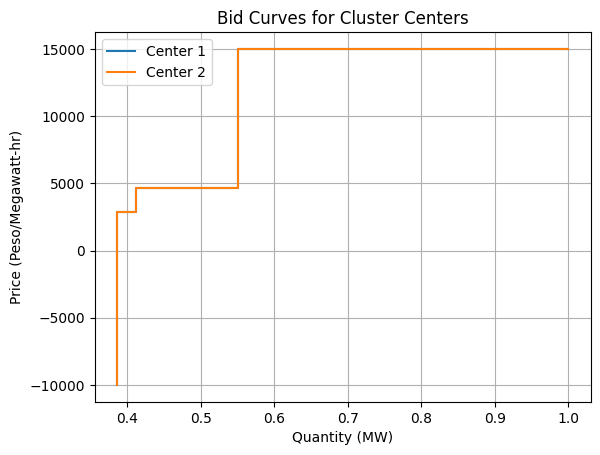

In [23]:
# Assuming 'centers_df' is your DataFrame
for i in range(len(centers_df)):
    cumulative_quantity, price = zip(*centers_df.iloc[i].values.reshape(-1, 2))
    plt.step(cumulative_quantity, price, where='pre', label=f'Center {i + 1}')

plt.xlabel('Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Bid Curves for Cluster Centers')
plt.legend()
plt.grid(True)
plt.show()


# [ARCHIVED] Sampling the bid curve

In [10]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022

# Reset the index of test_df
test_df.reset_index(drop=True, inplace=True)

In [10]:
%%time
# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for 'pre' step-wise interpolation
    step_fx = interp1d(quantities, prices, kind='previous', fill_value='extrapolate')

    # Get the original quantities for interpolation
    intp_quantities = np.array(quantities)

    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)

    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000

    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

Processing rows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62192/62192 [00:22<00:00, 2788.55it/s]

CPU times: total: 22.6 s
Wall time: 22.3 s


## Export Price series

In [11]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series

array([[-10000.  , -10000.  ,   2854.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  ,   2854.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  ,   2854.  , ...,  15000.08,  15000.08,
         15000.08],
       ...,
       [-10000.  , -10000.  ,   9200.08, ...,   9300.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  ,   9200.08, ...,   9300.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  ,   9200.08, ...,   9300.08,   9300.08,
          9300.08]])

In [12]:
all_prices_array = np.array(all_prices)
all_prices_array

array([[-10000.  , -10000.  ,   2854.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  ,   2854.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  ,   2854.  , ...,  15000.08,  15000.08,
         15000.08],
       ...,
       [-10000.  , -10000.  ,   9200.08, ...,   9300.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  ,   9200.08, ...,   9300.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  ,   9200.08, ...,   9300.08,   9300.08,
          9300.08]])

In [13]:
# # Specify the CSV file path
csv_file_path = 'E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01_price_series_nointerp.csv'

# # Save the array to a CSV file
np.savetxt(csv_file_path, price_series, delimiter=',')

print(f"Array has been saved to {csv_file_path}")

Array has been saved to E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01_price_series_nointerp.csv


## Plot select bid curves

In [14]:
# Find the index where 'price5' first becomes equal to 30k
index_first_32000 = test_df[test_df['price5'] == 30000.08]['price5'].idxmax()
index_first_32000

6348

In [15]:
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 1000, 6348, 11424, 20000, 30000, 40000, 62187]
# indices_to_plot = [6348]

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62192/62192 [00:00<00:00, 1126153.90it/s]


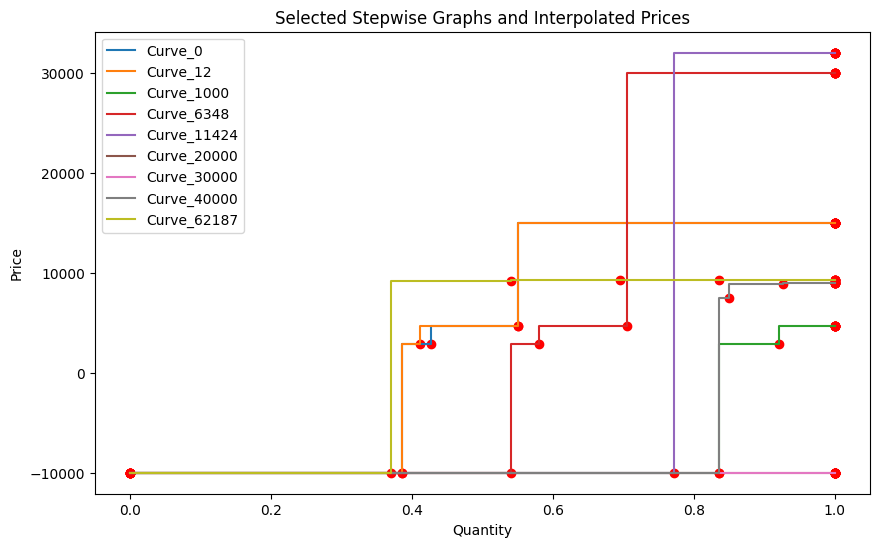

In [16]:
# Plot only the selected stepwise curves on a single graph
plt.figure(figsize=(10, 6))

for i, (quantities, prices, intp_quantities, intp_prices) in enumerate(tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing')):
    if i in indices_to_plot:
        plt.step(quantities, prices, where='pre', label=f'Curve_{i}')
        plt.scatter(intp_quantities, intp_prices, color='red')

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Selected Stepwise Graphs and Interpolated Prices')
plt.legend()
plt.show()

In [17]:
# Display the rows at specified indices
rows_to_display = test_df.loc[indices_to_plot]
rows_to_display

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/01/2022,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.426893,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
12,01/01/2022 01:00:00 AM,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.412056,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
1000,01/04/2022 11:20:00 AM,-10000.0,-10000.0,2862.20,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,4646.81,0.0,0.836167,0.921638,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
6348,01/23/2022 01:00:00 AM,-10000.0,-10000.0,2862.20,4646.81,30000.08,30000.08,30000.08,30000.08,30000.08,30000.08,30000.08,0.0,0.540958,0.580835,0.704791,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
11424,02/09/2022 04:00:00 PM,-10000.0,-10000.0,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,0.0,0.772798,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
20000,03/14/2022 10:00:00 PM,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,0.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
30000,04/23/2022 06:10:00 PM,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,0.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
40000,05/28/2022 01:00:00 PM,-10000.0,-10000.0,7500.08,8900.08,9000.08,9000.08,9000.08,9000.08,9000.08,9000.08,9000.08,0.0,0.836167,0.850077,0.927357,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
62187,12/31/2022 11:35:00 PM,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0


# K-medoids Chunking Attempt

In [18]:
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from tqdm.notebook import tqdm  # Import tqdm.notebook for Jupyter Notebook

In [19]:
# Function to calculate Wasserstein distance between two curves
def wasserstein_distance_between_curves(curve1, curve2):
    return wasserstein_distance(curve1, curve2)

# Function to calculate the proportion RHO_i
def calculate_proportion(distances, threshold):
    exceeding_threshold = np.sum(distances > threshold)
    return exceeding_threshold / len(distances)

In [20]:
def run_kmedoids_with_warnings(bidding_curves, K, theta_0, rho_0, s_ref, chunk_size):
    kmedoids = KMedoids(n_clusters=K)

    # Initialize variables
    k_t = K
    s_th = theta_0 * s_ref
    rho_0_percentage = rho_0 * 100

    # Use tqdm for the outer loop only
    for chunk_start in tqdm(range(0, len(bidding_curves), chunk_size), desc='Processing Chunks', leave=False, bar_format=''):
        chunk_end = min(chunk_start + chunk_size, len(bidding_curves))
        chunk = bidding_curves[chunk_start:chunk_end]

        if len(chunk) < K:
            # Skip chunks with insufficient samples for K-medoids
            continue

        try:
            kmedoids.fit(chunk)
            cluster_centers = kmedoids.cluster_centers_
        except UserWarning as e:
            print(f"Warning: {e}")
            continue

        distances = Parallel(n_jobs=-1)(
            delayed(wasserstein_distance_between_curves)(cluster_center, curve) for cluster_center in tqdm(cluster_centers, desc='Calculating Distances', leave=False) for curve in bidding_curves
        )

        # Check if the proportion exceeds the tolerance rate
        rhos = [calculate_proportion(distances, s_th) for _ in cluster_centers]

        if any(rho > rho_0 for rho in rhos):
            k_t += 1

    return k_t, cluster_centers

# Main iterative procedure to find the optimal number of clusters
def find_optimal_k(bidding_curves, k_max, theta_0, rho_0, chunk_size=100):
    k_0 = 2
    k_t = k_0

    # Calculate the Wasserstein distance between the initial two cluster centers
    s_ref = wasserstein_distance_between_curves(bidding_curves[0], bidding_curves[1])

    while k_t <= k_max:
        k_t, cluster_centers = run_kmedoids_with_warnings(bidding_curves, k_t, theta_0, rho_0, s_ref, chunk_size)

    return k_t, cluster_centers

In [21]:
%%time
# bidding_curves should be a 2D array where each row represents a bidding curve
# Adjust the values of k_max, theta_0, and rho_0 as needed
k_max = 30
theta_0 = 0.01  # 1% of the Wasserstein distance between the initial two cluster centers
rho_0 = 0.1  # Tolerance rate
chunk_size = 1000

# Call the main function to find the optimal number of clusters and get cluster centers
optimal_k, optimal_cluster_centers = find_optimal_k(all_intp_prices, k_max, theta_0, rho_0, chunk_size)

Processing Chunks:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: total: 3min 42s
Wall time: 2min 46s


In [22]:
optimal_k

65

In [23]:
optimal_cluster_centers

array([[-10000.  , -10000.  ,   9200.08,   9260.08,   9280.08,   9300.08,
          9300.08,   9300.08,   9300.08,   9300.08,   9300.08],
       [-10000.  , -10000.  ,   9200.08,   9260.08,   9280.08,   9300.08,
          9300.08,   9300.08,   9300.08,   9300.08,   9300.08]])

# K-medoids, 1st 1000 only

In [52]:
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn_extra.cluster import KMedoids
from joblib import Parallel, delayed
from tqdm import tqdm

# Function to calculate Wasserstein distance between two curves
def wasserstein_distance_between_curves(curve1, curve2):
    return wasserstein_distance(curve1, curve2)

# Function to calculate the proportion RHO_i
def calculate_proportion(distances, threshold):
    exceeding_threshold = np.sum(distances > threshold)
    return exceeding_threshold / len(distances)

In [53]:
# Function to run K-medoids clustering and check if the clusters meet the criteria
def run_kmedoids_and_check_clusters(bidding_curves, K, theta_0, rho_0, s_ref):
    kmedoids = KMedoids(n_clusters=K)
    kmedoids.fit(bidding_curves)
    cluster_centers = kmedoids.cluster_centers_

    # Initialize variables
    k_t = K
    s_th = theta_0 * s_ref
    rho_0_percentage = rho_0 * 100

    for i, cluster_center in enumerate(cluster_centers):
        distances = Parallel(n_jobs=-1)(
            delayed(wasserstein_distance_between_curves)(cluster_center, curve) for curve in tqdm(bidding_curves, desc='Calculating Distances')
        )

        # Check if the proportion exceeds the tolerance rate
        rho_i = calculate_proportion(distances, s_th)

        if rho_i > rho_0:
            k_t += 1
            break

    return k_t, cluster_centers

# Main iterative procedure to find the optimal number of clusters
def find_optimal_k(bidding_curves, k_max, theta_0, rho_0):
    k_0 = 2
    k_t = k_0

    # Calculate the Wasserstein distance between the initial two cluster centers
    s_ref = wasserstein_distance_between_curves(bidding_curves[0], bidding_curves[1])

    while k_t <= k_max:
        k_t, cluster_centers = run_kmedoids_and_check_clusters(bidding_curves, k_t, theta_0, rho_0, s_ref)

    return k_t, cluster_centers

In [60]:
# Truncate each array in the list to the first 10 entries
truncated_intp_prices = all_intp_prices[:1000]

# Truncate each array in the list to the first 10 entries
truncated_intp_quantity = all_intp_quantities[:1000]

In [55]:
# bidding_curves should be a 2D array where each row represents a bidding curve
# Adjust the values of k_max, theta_0, and rho_0 as needed
k_max = 30
theta_0 = 0.01  # 1% of the Wasserstein distance between the initial two cluster centers
rho_0 = 0.1  # Tolerance rate

In [56]:
%%time
# Call the main function to find the optimal number of clusters and get cluster centers
optimal_k, optimal_cluster_centers = find_optimal_k(truncated_intp_prices, k_max, theta_0, rho_0)

C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
Calculating Distances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 711.66it/s]
C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\Gaea\anaconda3\envs\textparse\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
Calculating Distances: 100%|█████████████████████████████████████████████████████████████

CPU times: total: 26.6 s
Wall time: 6.01 s


In [57]:
optimal_k

31

In [58]:
optimal_cluster_centers

array([[-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   2862.2 ,   4646.81,  15000.08,  15000.08,
         15000.08,  15000.08,  15000.08,  15000.08,  15000.08],
       [-10000.  , -10000.  ,   28

Processing: 30it [00:00, 1998.18it/s]


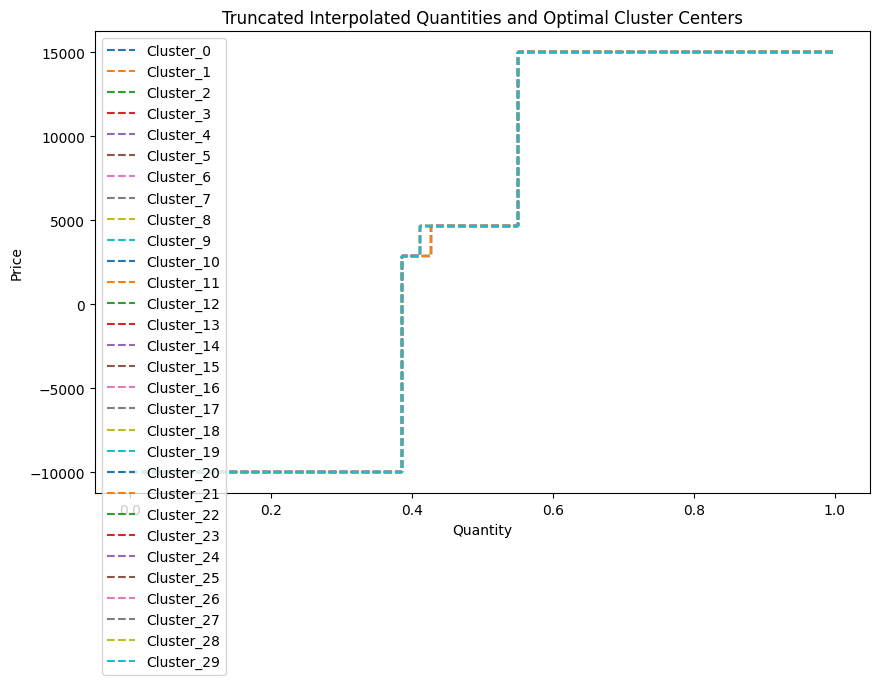

In [61]:
# Plot truncated_intp_quantity against optimal cluster centers
plt.figure(figsize=(10, 6))

for i, (cluster_prices, intp_quantity) in enumerate(tqdm(zip(optimal_cluster_centers, truncated_intp_quantity), desc='Processing')):
    plt.step(intp_quantity, cluster_prices, where='pre', label=f'Cluster_{i}', linestyle='--')  # Adjust linestyle as needed

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Truncated Interpolated Quantities and Optimal Cluster Centers')
plt.legend()
plt.show()

# [Archived] previous code

In [65]:
#Set Qmax
Q_max = 647.0

In [66]:
# Bidding curve sampling procedure
def bidding_curve_sampling(row):
    M = 11  # Set M to 10
    delta_q_i = Q_max / M
    q_sp = np.arange(0, Q_max + delta_q_i, delta_q_i)[:M]  # Adjust the range

    p_sp = []
    for i in range(1, M + 1):
        price_col = f'price{i}'
        quantity_col = f'quantity{i}'
        p_sp.append(row[price_col])

    return pd.Series({'P^SP': p_sp, 'q^SP': q_sp})

# Apply bidding curve sampling to each row (DU_i)
bidding_curve_df = result_df.apply(bidding_curve_sampling, axis=1)

# Unifying the data length by normalizing the bidding quantity
def normalize_bidding_curve(row):
    normalized_quantity = row['q^SP'] / Q_max
    return pd.Series({'q(m)': normalized_quantity, 'P^SP': row['P^SP']})

# Apply data normalization to each row
normalized_curve_df = bidding_curve_df.apply(normalize_bidding_curve, axis=1)

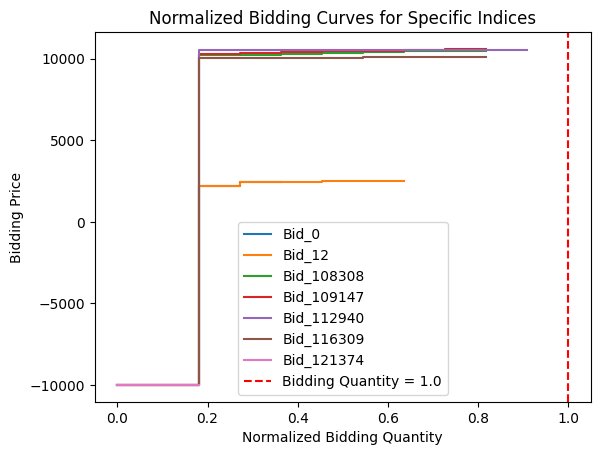

In [67]:
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 108308, 109147, 112940, 116309, 121374]

# Plot the bidding curves for the specified indices using plt.step
for index, row in normalized_curve_df.loc[indices_to_plot].iterrows():
    plt.step(row['q(m)'], row['P^SP'], label=f'Bid_{index}', where='post')

plt.axvline(x=1.0, color='red', linestyle='--', label='Bidding Quantity = 1.0')

plt.ylabel('Bidding Price')
plt.xlabel('Normalized Bidding Quantity')
plt.title('Normalized Bidding Curves for Specific Indices')
plt.legend()
plt.show()


In [68]:
bidding_curve_df

,P^SP,q^SP
0,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
1,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
2,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
3,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
4,"[-10000.0, -10000.0, 2214.38, 2465.69, nan, na...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
...,...,...
207765,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
207766,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
207767,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."
207768,"[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08...","[0.0, 58.81818181818182, 117.63636363636364, 1..."


In [69]:
# Access the 'q^SP' column for the 12th index
contents = bidding_curve_df.at[0, 'q^SP']

# Print the contents
print("Contents of index in 'q^SP' column:")
print(contents)

Contents of index in 'q^SP' column:
[  0.          58.81818182 117.63636364 176.45454545 235.27272727
 294.09090909 352.90909091 411.72727273 470.54545455 529.36363636
 588.18181818]


In [70]:
normalized_curve_df

,q(m),P^SP
0,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
1,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
2,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
3,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
4,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 2214.38, 2465.69, nan, na..."
...,...,...
207765,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."
207766,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."
207767,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."
207768,"[0.0, 0.09090909090909091, 0.18181818181818182...","[-10000.0, -10000.0, 5300.08, 5700.08, 6000.08..."


In [71]:
# Access the 'q^SP' column for the 12th index
cont = normalized_curve_df.at[0, 'q(m)']

# Print the contents
print("Contents of index in 'q(m)' column:")
print(cont)

Contents of index in 'q(m)' column:
[0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091]
